In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

import os
import kagglehub

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.basic Cleaning and Creating Train/Test Split
1.1 Reading in the data and inspection

In [2]:
# Download latest version
path = kagglehub.dataset_download("xiaomengsun/car-insurance-claim-data")

print("Path to dataset files:", path)
print("Contents:", os.listdir(path))

file_path = os.path.join(path, "car_insurance_claim.csv" )

# Load itt as a DataFrame
raw_data = pd.read_csv(file_path)

#Show the first few rows
pd.set_option('display.max_columns', None)
raw_data.head()

Path to dataset files: C:\Users\erika\.cache\kagglehub\datasets\xiaomengsun\car-insurance-claim-data\versions\1
Contents: ['car_insurance_claim.csv']


,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


### Variables and Descripctions
INDEX - Unique identifier  
TARGET_FLAG - Claim has been made  
TARGET_AMT - Claim value  
AGE - Age of driver  
BLUEBOOK - Value of vehicle  
CAR_AGE - Car age in years  
CAR_TYPE Type of vehicle  
CLM_FRQ - Number of claims in past 5 years  
EDUCATION - Highest level of education completed by policyholder  
HOMEKIDS - NUmber of child at policyholder's address  
HOME_VAL -  vALUE OF POLICYHOLDER'S HOME  
INCOME - Income of policy holder  
JOB - Type of job held by policyholder  
KIDSDRIV - Number of children with access to policyholder's vehicle  
MSTATUS - marital status  
OLDCLAIM - Total value of claims in part 5 years  
PARENT1 - Single parent  
RED_CAR - Vehicle is red in colour  
REVOKED - Licence has been revoked in past 7 years  
SEX - Gender  
TIF -  Policy tenure  
TRAVTIME - Commute distance  
URVANCITY - Address area type (urban/rural)  
TOJ - Years polyholder's job has been held for  

We don't want to fundamentely change any data as we still not split our data into a test/train set. So we want to avoid any data leakage

#### 1.2 Basic Data Cleaning 


In [3]:
# Create new copy of data
data_df = raw_data.copy()

In [4]:
# define updated column names
col_names = {
       'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'

}

# Update col names
data_df.rename(columns = col_names, inplace = True)


In [5]:
# Summary the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [6]:
# Check for duplicate records
data_df.duplicated().sum()

np.int64(1)

In [7]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

In [8]:
# Define currency cols
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', "", regex = True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)


In [9]:
data_df.columns

Index(['ID', 'num_young_drivers', 'date_of_birth', 'age', 'num_of_children',
       'years_job_held_for', 'income', 'single_parent', 'value_of_home',
       'married', 'gender', 'highest_education', 'occupation', 'commute_dist',
       'type_of_use', 'vehicle_value', 'policy_tenure', 'vehicle_type',
       'red_vehicle', '5_year_total_claims_value', '5_year_num_of_claims',
       'licence_revoked', 'license_points', 'new_claim_value', 'vehicle_age',
       'is_claim', 'address_type'],
      dtype='object')

In [10]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,z_No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,z_No,M,z_High School,z_Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,z_No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,z_F,z_High School,Clerical,5,Private,4010,4,z_SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,z_Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [11]:
# Define cols that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create a function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex = True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)




In [12]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [13]:
# Drop features we don't need
data_df.drop(['ID', 'date_of_birth'], axis = 1, inplace = True)

In [14]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


when creating our sets, we want to make sure there's no bias in the negative or positive classes. So that the sets are actually reprsentative of the customer data. To be clear, when I say the positive and negative classes I'm referring to the Target variable which in this project for the classification is the "is_claim" feature. The positive class is that the customer has made a claim and the negative class that they haven't made a claim. Since we have a feature that describes a claim value of customers that have claimed we can use this to do something called stratified sampling. This will avoid bias in the test set.  
We can create bins based on non-zero values for the claim value as thsi implies indirectly that the 'is_claim' feature is true, but we can double check this to make sure our assumptions is correct.

1.3 Create Train/Test Split

In [15]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1
mask = (data_df['new_claim_value'] > 0 ) & (data_df['is_claim'] ==0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


In [16]:
# Create histoplot for new Claim values

fig = px.histogram(data_df, x="new_claim_value", nbins = 10)
fig.show()


We can see that this shows a heavy  right skew. So when creating our strata bins it might be wise to create nonlinearly spaced bins to better capture the moer extreme values with few instances.

In [17]:
# Define bins
bins = list(range(0, 50001, 5000 )) + [np.inf]

# Define bin labels
labels = np.arange(1,12)

# Apply bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels = labels, include_lowest= True)

In [18]:
bins

[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, inf]

<Axes: ylabel='claim_value_cat'>

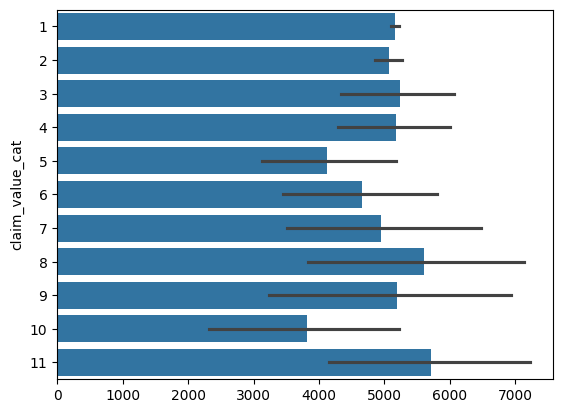

In [19]:
sns.barplot(data_df['claim_value_cat'])

It's improtant t ohave a sufficient number of each stratum in the data set or else the estimate of each stratum's importance might be biased

In [20]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type,claim_value_cat
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban,1


In [21]:
# Show distributions with barplot
df = data_df['claim_value_cat'].value_counts().sort_values().reset_index()
df.columns = ['claim_value_cat', 'count']


fig = px.bar(df, x='claim_value_cat', y = 'count')
fig.show()

In [23]:
# Create copy of data
X = data_df.copy()
y = data_df['is_claim']

# Drop target features from X
X.drop(columns = ['new_claim_value', 'is_claim'], inplace = True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42, stratify = X['claim_value_cat'])
# Stratify argument is to stritify sampling 

In [25]:
# Check positive/negativa class ratio for y_train and y_test
# Quick check to make sure that the positive and n egative classes for ther target distribution in the test set are 
# representative of the train set. We can easily do this by summing instances were true is equal to 1 and falses is equal to zero.
# And then dividing by t he total a number of instances
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round(y_test.sum()/len(y_test)*100,2)

print(f'train positive class ration : {train_ratio}%')
print(f'Test positive class ration: {test_ratio}%')

train positive class ration : 26.48%
Test positive class ration: 27.37%


In [ ]:
# Remove bins from each set
for set_ in (X_train, X_test):
    set_.drop(columns = ['claim_value_cat'], inplace= True)

#### 2. Exploratory Data Analysis (EDA)
2.1 Preparation

In [28]:
# For the purpose of exploring our correlations between predictiors and the target variable
# We are joining X_train and y_train so that we have the predictors and the target variabole in the same dataframe
# As some of the features are categorical, we won~t be able to look at their correlation with this claim
# We can make some changes to the binary categorical columns to easily fix this
# Create new copy of X_train for analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [30]:
# Define binary cols
# I'll create a list that defines the binary columns then create a map that updates theses values from text
# to zeros or ones

# Define binary cols
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = { 'Yes' : 1,
           'No' : 0,
           'yes' : 1,
           'no' : 0,
           'M' : 1,
           'F' : 0}

# Define function to binarize features
def binarize_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarize_values(eda_test_data, binary_cols, mapping)

In [31]:
# Check updated values
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,claim_value_cat,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,1,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,1,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,2,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,1,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,1,0


2.2.Correlation matrix

In [33]:
# We can now go ahead and investigate how each of our features correlates with is claim feature
corr_matrix = eda_test_data.corr(numeric_only = True).sort_values(['is_claim'], ascending = True)

In [34]:
corr_matrix_no_claim = corr_matrix.drop('is_claim')

<Axes: >

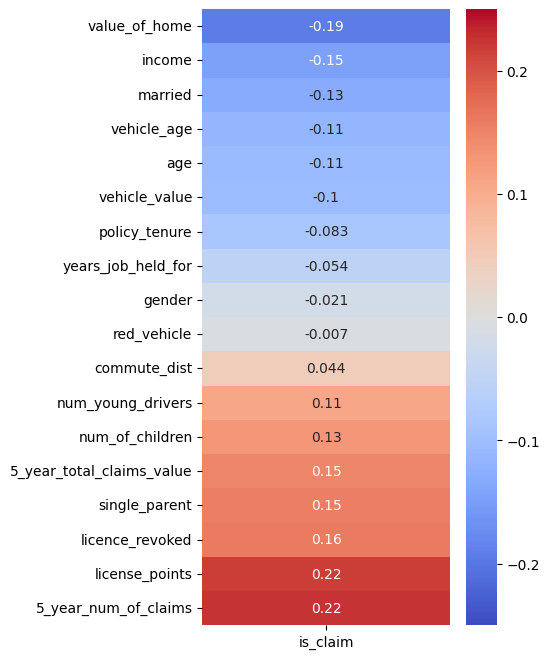

In [37]:
# Create a heatmap
fig, ax = plt.subplots(figsize = (4,8))
sns.heatmap(corr_matrix_no_claim[['is_claim']], cmap= 'coolwarm', annot= True, vmax = 0.25, vmin = -0.25)

We can't infer causation but we can speculate. The total number of claims in the past 5 years might suggest that the more a person is claimed in the past the more likely they might be are to claim again in the future. With license poinst, the more points they have might suggest a lower quality of driving and might reflect their likelihood to claim again in the future. Then looking at the strongest negative correlation, we can see that home value is the strongest and income the next strongest . We can also see in the center, with very negligible correlationthe red vehicle feature. It could be somthing of an urban myth that relates to red cars and that they're more likely to be involved in accidents, but we can see from our data at least that doesn't appear to be true.

### 3. Dta Cleaning and Preprocessing
3.1 Dropping Features

In [38]:
X_train_raw = X_train.copy()

# Define cols to drop
cols_to_drop = ['red_vehicle']

# Drop cols
X_train_raw.drop(columns = cols_to_drop, axis = 1, inplace = True)

### 3.2. Handling Missing values


In [39]:
# Check the number of missing values 
X_train_raw.isnull().sum().sum()

np.int64(2418)

In [ ]:
# Check how many missingg values by feature
X_train_raw.isnull().sum()


num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
claim_value_cat                0
dtype: int64

In [41]:
# For the numerical features using a simple imputer with a strategy like mean or median might be too naive for our model 
# We can try be a bit more intelligent and use a k nearest neighbors imputer or knn imputer
# the k nearest neighbors imputer will take the nearest information it has available ans interpolate to input a value

# Create imputer
knn_inputer = KNNImputer(n_neighbors=2)

# Define the numerical cols
numerical_cols_df = X_train_raw.select_dtypes(include = ['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorical cols to use later
cat_cols_df = X_train_raw.select_dtypes(include = ['object'])
cat_cols = cat_cols_df.columns.tolist()

In [42]:
#  Define function to inpute numerical features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Call function to impute values
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_inputer)


In [44]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop = True)

# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis = 1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [45]:
# Show same records as above but after imputation 
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


Categorical feature imputation

In [46]:
# For the categorical value, I'm gonan use a simpel imputer and inpute the most common value
simple_imputer = SimpleImputer(strategy = 'most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Call fucntion to impute cat features
cat_test_ata_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)



In [47]:
# Get categorical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop = True)

# Select rows with missing values and show head
cat_missing_data_df = cat_cols_df[cat_cols_df.isna().any(axis = 1)]
cat_missing_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,NaN,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,NaN,Commercial,Panel Truck,No,Highly Rural/ Rural


In [48]:
# Show same records as above but after imputation 
samples = cat_missing_data_df.index.to_list()
cat_test_ata_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,Blue Collar,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,Blue Collar,Commercial,Panel Truck,No,Highly Rural/ Rural


Rejoin numerical and categorical ata following imputation

In [49]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_ata_imputed], axis = 1)

# Check data
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


In [50]:
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

We now need to look at encoding our categorical features. Most machine learning algorithms need numerical data to work with, so we need to convert our text based categorical data t o numerical values. That's essentially all encoding is but there's several methods to do that. 

#### 3.4. Categorical Features Encoding

In [51]:
cat_test_ata_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

We can see that msot of the features has 2 unique values, this means that we can just consider these as binary values, zero or one.
Highest education has 5 different values, and it's improtante to note here that they do have an order or ranking. So gettinga PhD for instance is a higher ranking than graduating to high School. The presence of this ranking means that this is an ordinal feature and this isn't true for all categorical features. 
For example, occupation has eight unique values, but thre's no ranking or order to them. The same is true for car type, for these non-binary non-ordinal features we need to do something called one hot encoding.
One hot encoding creates a new column or feature for each uniqeu value of existing feature only one of these new features that's created is equal to one, and hence why it's called one hot encoding. So we can use one hot encoding for occupation and car type and we use ordinal encoding for highest education level. The remaining categorical features we use binary encoding.

In [60]:
#  Define ordinal features
cat_cols_ord = ['highest_education']
# Define finary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [61]:
# Create encoders

# First define education rank/order
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories = education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

Fit/transform encoders

In [62]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_ata_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_ata_imputed[cat_cols_bin])

# Encode with one-hot
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_ata_imputed[cat_cols_one_hot])

In [64]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Joina ll encoded dfs to a sinlge
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis = 1)
all_cat_encoded_df.head()



,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [66]:
# Bring numerical and categorical data back together
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis = 1)

